# Nearest Neighbor Classification - KNN and Conformal Prediction

* [Importing libraries](#Importing-libraries)
* [Loading Data](#Loading-Data)
* [Custom functions](#Custom-functions)
* [Prediction algorithm KNN](#Prediction-algorithm-KNN)
* [Running prediction for Iris](#Running-prediction-for-Iris)
* [Running prediction for Ionosphere](#Running-prediction-for-Ionosphere)
* [Choosing best K for Iris](#Choosing-best-K-for-Iris)
* [Choosing best K for Ionosphere](#Choosing-best-K-for-Ionosphere)
* [Conformal Prediction](#Conformal-Prediction)
* [Conformal Prediction Algorithm](#Conformal-Prediction-Algorithm)
* [Running Conformal Prediction for Iris ](#Running-Conformal-Prediction-for-Iris)
* [Running Conformal Prediction for Ionosphere ](#Running-Conformal-Prediction-for-Ionosphere)

## Importing libraries 

In [30]:
import sys
import time

import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

## Loading Data

In [31]:
iris_data = load_iris()
ionosphere_data = np.genfromtxt("ionosphere.txt", delimiter=',', names=True, dtype=None)

In [32]:
iris_data

iris_X = iris_data['data']
iris_y = iris_data['target']

In [33]:
ionosphere_data
list_data = [list(x) for x in ionosphere_data]
iono_X = []
iono_y = []
for i,d in enumerate(list_data):
    iono_X.append([x for j,x in enumerate(d) if j!=len(d)-1])
    iono_y.append([x for j,x in enumerate(d) if j==len(d)-1])

iono_X = np.array(iono_X)
iono_y = np.hstack(iono_y)
iono_y = np.where(iono_y == 1, 1, 0) #converting to 0 and 1 for simplicity


___The data consists of one duplicate value, which will result in `0` euclidean distance, which we will omit at that part___

In [34]:
str_X = [str(i) for i in iris_X]
str_X1 = [str(i) for i in iono_X]
print(len(str_X), len(str_X1))

print(len(set(str_X)), len(set(str_X1)))

150 350
149 349


##  Custom functions

In [35]:
def sort_it(list_to_sort):    
    try:
        for i in range(len(list_to_sort)):
            for j in range(len(list_to_sort) - 1):
                if list_to_sort[j] > list_to_sort[j+1]:
                    list_to_sort[j], list_to_sort[j + 1] = list_to_sort[j + 1], list_to_sort[j]
                
        return list_to_sort
    except:
        print(sys.exc_info())

## Prediction algorithm KNN

In [36]:
def run_prediction(X, y, test_size=0.3, train_size=0.7, random_state=3006, k=1):
    
    if(test_size+train_size > 1 or test_size+train_size < 0):
        print("The sum of test_size and train_size should be between 0 and 1")
        return
    
    prediction = {"predicted_list" : [], "accuracy" : 0}
    
    try:
        # splitting test train data
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, random_state=random_state)

        predicted_list = []
    
        # training on X_train, y_train by calculating Euclidean distances
        for d in range(len(X_test)):
            eucl_distances = []
            for i in range(len(X_train)):
                #eucl_distances.append([np.sqrt(np.sum(np.power(X_test[d,:] - X_train[i,:], 2))), i])
                eucl_distances.append([np.linalg.norm(X_test[d,:] - X_train[i,:]), i]) #used linalg for faster calculation time
                
            eucl_distances = sort_it(eucl_distances)
            #print(eucl_distances)
    
            targets = [y_train[eucl_distances[i][1]] for i in range(k)]
            #print(targets)
        
            predicted_list.append(max(targets, key=targets.count))

        #print(predicted_list)
        prediction['predicted_list'] = predicted_list
        prediction['accuracy'] = np.mean(prediction['predicted_list'] == y_test)
        return prediction
    
    except:
        print(sys.exc_info())

### Running prediction for Iris

In [37]:
try :
    nn = run_prediction(iris_X, iris_y, test_size=0.3,train_size=0.7, random_state=3006, k=1)
    print(nn["accuracy"])
except:
    print(sys.exc_info()) 


0.9555555555555556


### Running prediction for Ionosphere

In [38]:
try :
    nn = run_prediction(iono_X, iono_y, test_size=0.3,train_size=0.7, random_state=3006, k=1)
    print(nn["accuracy"])
except:
    print(sys.exc_info()) 

0.9142857142857143


### Choosing best K for Iris

['0.96', '0.96', '0.96', '0.96', '0.98', '0.98', '1.00', '1.00', '1.00', '1.00', '1.00', '0.98', '0.98', '0.98', '1.00', '0.98', '1.00', '1.00', '1.00', '1.00', '1.00', '0.98', '0.98', '0.98']


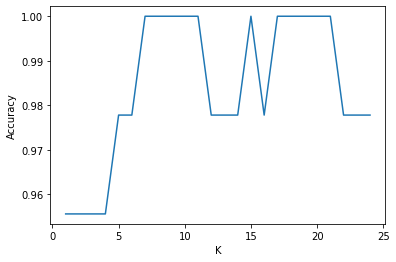

In [39]:
k_neighbors = list(range(1,25))
accuracy_scores = [run_prediction(iris_X, iris_y, test_size=0.3,train_size=0.7, random_state=3006, k=s)["accuracy"] for s in k_neighbors]
print(["{:.2f}".format(t) for t in accuracy_scores])

plt.plot(k_neighbors, accuracy_scores)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

###  Choosing best K for Ionosphere

['0.91', '0.91', '0.87', '0.90', '0.87', '0.87', '0.85', '0.86', '0.86', '0.86', '0.86', '0.86', '0.87', '0.87', '0.87', '0.87', '0.87', '0.87', '0.87', '0.87', '0.87', '0.87', '0.87', '0.87']


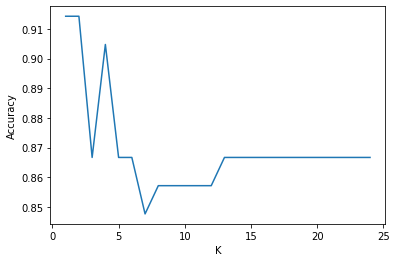

In [40]:
k_neighbors = list(range(1,25))
accuracy_scores = [run_prediction(iono_X, iono_y, test_size=0.3,train_size=0.7, random_state=3006, k=s)["accuracy"] for s in k_neighbors]
print(["{:.2f}".format(t) for t in accuracy_scores])

plt.plot(k_neighbors, accuracy_scores)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

## Conformal Prediction Algorithm

In [41]:
def calculate_distance(X_tr, y_tr):
    train_length = X_tr.shape[0]
    same_class_dist, other_class_dist = [[math.inf for i in range(train_length)] for j in range(2)]

    for i in range(train_length-1):
        for j in range(i+1,train_length):
            distance = np.linalg.norm(X_tr[i]-X_tr[j])

            if y_tr[i]==y_tr[j]:
                if distance < same_class_dist[i]:
                    same_class_dist[i] = distance
                if distance < same_class_dist[j]:
                    same_class_dist[j] = distance
            else:
                if distance < other_class_dist[i]:
                    other_class_dist[i] = distance
                if distance < other_class_dist[j]:
                    other_class_dist[j] = distance

    return [same_class_dist, other_class_dist]

In [47]:
def conformal(X, y, dataset, test_size=0.3, train_size=0.7, random_state=3006):
    predicted_list, p_values = [[] for i in range(2)]
    # splitting the data
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, random_state=random_state)
    lenrange = len(list(set(y_train)))
    same_class_dist, other_class_dist = calculate_distance(X_train, y_train)

    for i in range(len(X_test)):
        conformity_scores = [[] for j in range(lenrange)]
        curr_testXval = X_test[i]
        for j in range(lenrange):
            new_same_dist = np.append(same_class_dist, math.inf)
            new_other_class_dist = np.append(other_class_dist, math.inf)
            extended_X = np.concatenate((X_train, [curr_testXval]), axis = 0)
            extended_y = np.concatenate((y_train, [j]), axis = 0)

            for curr_idx, curr_elem in enumerate(extended_X):
                distance = np.linalg.norm(curr_elem - curr_testXval)
                idx = len(extended_X)-1

                if distance != 0: #to avoid duplicate value
                    if j == extended_y[curr_idx]:
                        if distance < new_same_dist[idx]:
                            new_same_dist[idx] = distance
                    else:
                        if distance < new_other_class_dist[idx]:
                            new_other_class_dist[idx] = distance

                if new_same_dist[curr_idx] == 0: #to avoid duplicate value
                    conformity_scores[j].append(0)
                else:
                    conformity_scores[j].append(new_other_class_dist[curr_idx]/new_same_dist[curr_idx])

        p_vals = []
        for k in range(lenrange):
            p_vals.append(np.mean(conformity_scores[k]<=conformity_scores[k][X_train.shape[0]]))

        predicted_list.append(p_vals.index(max(p_vals)))
        p_values.append(p_vals)

    falsep = []
    for i, p in enumerate(p_values):
        sumval = 0;
        for j, q in enumerate(p):
            if j != y_test[i]:
                sumval += q
        falsep.append(sumval)

    false_p_value = np.sum(falsep)/(len(falsep)*2)
    accuracy = np.mean(predicted_list == y_test)

    print("For {}, "
          "The average false p-value : {} \n"
          "The accuracy of prediction : {} \n"
          "The test error rate is : {}"
          .format(dataset, false_p_value, accuracy, 1-accuracy))

## Running Conformal Prediction for Iris 

In [48]:
start_time = time.time()
try :
    conformal(iris_X, iris_y, "iris dataset", test_size=0.3,train_size=0.7, random_state=3006)
except:
    print(sys.exc_info()) 
print("\nTime elapsed : %s seconds" % (time.time() - start_time))

For iris dataset, The average false p-value : 0.030817610062893092 
The accuracy of prediction : 0.9555555555555556 
The test error rate is : 0.0444444444444444

Time elapsed : 0.1819469928741455 seconds


## Running Conformal Prediction for Ionosphere

In [49]:
start_time = time.time()
try :
    conformal(iono_X, iono_y, "ionosphere dataset", test_size=0.3,train_size=0.7, random_state=3006)
except:
    print(sys.exc_info()) 
print("\nTime elapsed : %s seconds" % (time.time() - start_time))

For ionosphere dataset, The average false p-value : 0.028862973760932945 
The accuracy of prediction : 0.9142857142857143 
The test error rate is : 0.08571428571428574

Time elapsed : 0.9404799938201904 seconds
